In [1]:
import pandas as pd
import numpy as np 
import rasterio 
import os
from glob import glob 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from loguru import logger


In [2]:
sentinel_data_df = pd.read_csv("/nas/cee-water/cjgleason/S2_Validation/GLOWS_widths_label_reaches.csv") # from Dongmei
sentinel_data_df["reach_id"] = sentinel_data_df["SWORD_reachid"]
sentinel_data_df["sentinel_width"] = sentinel_data_df["width"]
sentinel_data_df = sentinel_data_df[["reach_id", "sentinel_width"]]
sentinel_data_df = sentinel_data_df.groupby("reach_id").mean().reset_index()
sentinel_data_df.shape

(613, 2)

In [3]:
swot_data = pd.read_csv("/nas/cee-water/cjgleason/taylor/YR Unit /Yukonsubsample_20240401_20241031_v16.csv")
swot_data

,reach_id,time_str,width,width_u,sword_version,crid,width_units,width_u_units
0,81280600191,2024-04-06 23:58:59,49.665682,0.274000,16,PIC0,m,m
1,81280600191,2024-04-17 22:21:50,133.944846,0.961474,16,PIC0,m,m
2,81280600191,2024-04-26 05:30:45,73.596873,1.051036,16,PIC0,m,m
3,81280600191,2024-04-27 20:44:05,65.363245,0.472152,16,PIC0,m,m
4,81280600191,2024-05-06 03:53:00,114.590775,0.583923,16,PIC0,m,m
...,...,...,...,...,...,...,...,...
12132,81210500301,2024-10-11 20:26:48,1733.448037,1.483201,16,PIC0,m,m
12133,81210500301,2024-10-12 05:16:09,3034.486248,5.043505,16,PIC0,m,m
12134,81210500301,2024-10-12 20:27:29,1778.970395,1.622716,16,PIC0,m,m
12135,81210500301,2024-10-22 18:49:37,7535.632163,155.486146,16,PIC2,m,m


In [4]:
swot_data = swot_data[swot_data["width"]>0]
swot_data["reach_id"].value_counts()


swot_widths = swot_data[["reach_id", "width"]]
swot_widths = swot_widths.groupby("reach_id").mean().reset_index()
swot_widths = swot_widths[swot_widths["width"]>0]
swot_widths = swot_widths.rename(columns={"width": "swot_width"})
swot_widths.shape

(250, 2)

In [5]:
# swot_data = pd.read_csv("/work/pi_smaji_umass_edu/rdaroya/planet-benchmark/swot_widths.csv")
# swot_data

In [6]:
all_planet_widths = None
for fp in tqdm(glob(os.path.join("predicted_widths", "*.csv"))):
    tmp = pd.read_csv(fp)
    if all_planet_widths is None:
        all_planet_widths = tmp
    else:
        all_planet_widths = pd.concat([all_planet_widths, tmp])
print(all_planet_widths.shape)

  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [00:00<00:00, 279.76it/s]

(12210, 11)


In [7]:
len(all_planet_widths["reach_id"].unique()), all_planet_widths.columns

(321,
 Index(['reach_id', 'planet_fp', 'cloud_cover', 'pred_raster_fp',
        'reach_len_full', 'reach_len_raster_bound', 'reach_len_pred_bound',
        'num_water_px', 'perc_water_px', 'water_area', 'sword_width'],
       dtype='object'))

In [8]:
all_planet_widths = all_planet_widths[all_planet_widths["cloud_cover"]<=0.3]
print(len(all_planet_widths["reach_id"].unique()))
all_planet_widths["diff_raster_pred_len"] = all_planet_widths["reach_len_raster_bound"]-all_planet_widths["reach_len_pred_bound"]
all_planet_widths = all_planet_widths[all_planet_widths["diff_raster_pred_len"]<=500]   # only use predictions that have <=500m difference between raster bounds and pred bounds (to filter out super wrong predictions)
print(len(all_planet_widths["reach_id"].unique()))

320
306


In [9]:
all_planet_widths["planet_fp"].iloc[0]

'/project/pi_cjgleason_umass_edu/swot_planet/unit/81260300091.0/85d31913-2e09-4386-ba10-0811318a31a9/PSScene/20240619_212933_22_2477_3B_AnalyticMS_SR_clip.tif'

In [10]:
fp = "81210100041.0--23810af8-d590-44e5-8d82-401a7170e44f--PSScene--20240922_223015_38_24fd_3B_AnalyticMS_SR_clip.tif"
planet_fp = os.path.join("/project/pi_cjgleason_umass_edu/swot_planet/unit/", "/".join(fp.split("--")))
assert os.path.exists(planet_fp)
all_planet_widths[all_planet_widths["planet_fp"]==planet_fp]


,reach_id,planet_fp,cloud_cover,pred_raster_fp,reach_len_full,reach_len_raster_bound,reach_len_pred_bound,num_water_px,perc_water_px,water_area,sword_width,diff_raster_pred_len
19,81210100041,/project/pi_cjgleason_umass_edu/swot_planet/un...,0.0,tiled_planet_predicted_merged/81210100041.0--2...,16599.78875,16674.526148,16364.440832,3470523,0.141685,31234707,1887.0,310.085316


In [11]:
sword_widths = all_planet_widths[["reach_id", "sword_width"]]
sword_widths = sword_widths.groupby("reach_id").mean().reset_index()
sword_widths = sword_widths[sword_widths["sword_width"]>0]
sword_widths.shape

(306, 2)

In [12]:
planet_widths = all_planet_widths[["reach_id", "water_area", "reach_len_pred_bound"]]
planet_widths = planet_widths.groupby("reach_id").sum().reset_index()
planet_widths["effective_width"] = planet_widths["water_area"]/planet_widths["reach_len_pred_bound"]
planet_widths.shape

(306, 4)

In [13]:
merged_res = planet_widths.merge(sentinel_data_df, how="left", on="reach_id")
merged_res = merged_res.merge(sword_widths, how="left", on="reach_id")
merged_res = merged_res.merge(swot_widths, how="left", on="reach_id", suffixes=("","_swot"))

In [19]:
print(merged_res[merged_res["sentinel_width"]>0].shape)
print(merged_res[merged_res["sword_width"]>0].shape)
print(merged_res[((merged_res["sword_width"]>0)&(merged_res["swot_width"]>0))].shape)

(3, 7)
(306, 7)
(107, 7)


In [16]:
merged_res[merged_res["sentinel_width"]>0][["reach_id", "effective_width",	"sentinel_width",	"sword_width", "swot_width"]]

,reach_id,effective_width,sentinel_width,sword_width,swot_width
216,81270501211,610.489074,610.509556,573.0,NaN
228,81280500401,182.476834,262.720204,190.0,NaN
259,81293000121,626.159260,476.620499,438.0,NaN


In [21]:
EPS=1e-6
sword_mae = (merged_res["effective_width"]-merged_res["sword_width"]).abs().mean()
sword_median_abs = (merged_res["effective_width"]-merged_res["sword_width"]).abs().median()
sword_bias = -(merged_res["effective_width"]-merged_res["sword_width"]).mean()
sword_perc_bias = (-(merged_res["effective_width"]-merged_res["sword_width"])/(merged_res["effective_width"]+EPS)).mean()


swot_mae = (merged_res["effective_width"]-merged_res["swot_width"]).abs().mean()
swot_median_abs = (merged_res["effective_width"]-merged_res["swot_width"]).abs().median()
swot_bias = -(merged_res["effective_width"]-merged_res["swot_width"]).mean()
swot_perc_bias = (-(merged_res["effective_width"]-merged_res["swot_width"])/(merged_res["effective_width"]+EPS)).mean()

print(sword_mae, sword_median_abs, sword_bias, sword_perc_bias)
print(swot_mae, swot_median_abs, swot_bias, swot_perc_bias)

122.10510375561931 46.80916641482111 -84.5692038919577 -0.10060714725052183
176.92639196804816 78.11127469072284 64.02336579193329 1.5331425743666138


In [22]:
EPS=1e-6

# filter results to those that have SWORD and SWOT widths
filtered_res = merged_res[((merged_res["sword_width"]>0)&(merged_res["swot_width"]>0))]

sword_mae = (filtered_res["effective_width"]-filtered_res["sword_width"]).abs().mean()
sword_median_abs = (filtered_res["effective_width"]-filtered_res["sword_width"]).abs().median()
sword_bias = -(filtered_res["effective_width"]-filtered_res["sword_width"]).mean()
sword_perc_bias = (-(filtered_res["effective_width"]-filtered_res["sword_width"])/(filtered_res["effective_width"]+EPS)).mean()


swot_mae = (filtered_res["effective_width"]-filtered_res["swot_width"]).abs().mean()
swot_median_abs = (filtered_res["effective_width"]-filtered_res["swot_width"]).abs().median()
swot_bias = -(filtered_res["effective_width"]-filtered_res["swot_width"]).mean()
swot_perc_bias = (-(filtered_res["effective_width"]-filtered_res["swot_width"])/(filtered_res["effective_width"]+EPS)).mean()

print(sword_mae, sword_median_abs, sword_bias, sword_perc_bias)
print(swot_mae, swot_median_abs, swot_bias, swot_perc_bias)

114.40068512956637 42.460603313928374 -76.67902241133112 -0.020930340602853016
176.92639196804816 78.11127469072284 64.02336579193329 1.5331425743666143


In [24]:
filtered_res.shape

(107, 7)

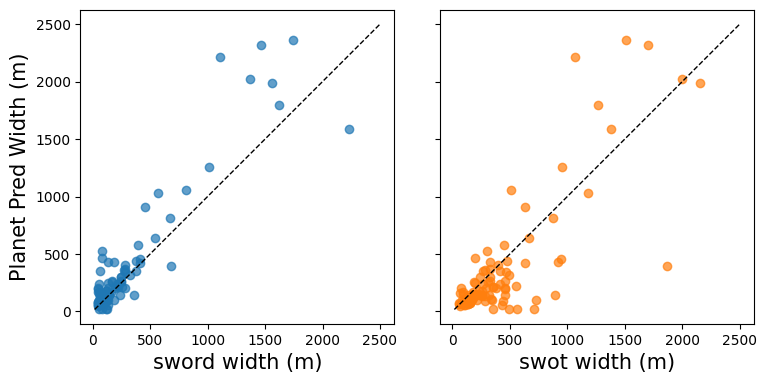

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# Configuration ‒ tweak as you like
x_columns = ['sword_width',"swot_width"]          # x-axis columns (left➜right)
y_column  = 'effective_width'        # shared y-axis
colors    = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
figsize   = (4*len(x_columns), 4)
alpha_pts = 0.7                      # scatter opacity
line_kw   = dict(color='black', ls='--', lw=1)  # y=x line style
# ------------------------------------

# Ensure data is in good shape (adjust if you want to keep NaNs)
data = merged_res.dropna(subset=x_columns + [y_column])

fig, axes = plt.subplots(1, len(x_columns), figsize=figsize, sharey=True)

for ax, x_col, c in zip(axes, x_columns, colors):
    # scatter points
    ax.scatter(data[x_col], data[y_column], alpha=alpha_pts, color=c)
    
    # y = x reference line
    vmin = min(data[[x_col, y_column]].min())
    vmax = max(data[[x_col, y_column]].max())
    ax.plot([vmin, 2500], [vmin, 2500], **line_kw)
    # ax.set_xlim(vmin, vmax)
    # ax.set_ylim(vmin, vmax)
    # ax.set_xlim(0, 500)
    # ax.set_ylim(0, 500)

    # labels & title
    ax.set_xlabel(x_col.replace('_', ' ')+" (m)", fontsize=15)
    # ax.set_title(f'{x_col} vs {y_column}', fontsize=20)
    ax.set_aspect('equal', adjustable='box')   # keeps squares looking square

# axes[0].set_ylabel(y_column.replace('_', ' ').title(), fontsize=20)
axes[0].set_ylabel("Planet Pred Width (m)", fontsize=15)
# fig.tight_layout()
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
